# Project #6：FM demodulation








(Due Date: 21/12/2023, class time)

Junhao Zhu

Ruiqi Zhao

## PJ5 Functions


In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat Dec  2 15:31:47 2023
Finished on Thu Dec  7 17:44:30 2023

@author: Suhao Wang
"""

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq
import math
    

# Define the message signal
def square_pulse(t,T1,dt,amplitude):
    return np.where((t >= T1-dt/2) & (t <= T1+dt/2), amplitude, 0)

# def message_signal(t,duration,Am):
#     #return np.where((t >= 0) , t, 0)
#     #return Am * np.sin(2 * np.pi * fm * t) 
#     return square_pulse(t,0,duration,Am)


# Generate the FM signal with kf, Fc and mt
def generate_fm_signal(t, Fs, m_t, mykf, myFc):
    # "np.cumsum(m_t) / Fs" is the integral "array" from -5 (the start of numpy array) to t
    phi_t = 2 * np.pi * myFc * t + 2*np.pi* mykf * np.cumsum(m_t) / Fs  # Phase deviation
    fm_signal = np.cos(phi_t)  # FM signal
    return fm_signal

### Numerical Approach
#   func. find_bandwidth integarte to get the approximated band width
#   The func. will return the approximated bandwidth
#   1. calculate bandwidth from Fc to left until 0 and from fc to right until "infinite"
#   2. make sure that fc>fm+kf*Am
def calculate_bandwidth(f, Y, center, accuracy):
    # parameters
    step = (max(f) - min(f)) / len(f)
    n = len(Y)
    n_half = math.floor(n / 2)
    energy = np.zeros(n)
    df = f[1]-f[0]
    step = df
    ## df is 0.1, step 0.099995


    # total energy in positive axis
    energy[0] = step * math.pow(Y[0], 2)
    for i in range(1, n_half):
        energy[i] = energy[i - 1] + step * math.pow(Y[i], 2)

    # band_energy we need in positive axis
    total_energy = energy[n_half-1]
    band_energy = accuracy * total_energy
    
    # move
    center_index = (int)(center*1/step)
    energy[0] = step * math.pow(Y[center_index], 2)

    for i in range(1, n_half-center_index):
        energy[i] = energy[i - 1] + step * math.pow(Y[i+center_index], 2)
        if center_index-i>=0:
            energy[i] = energy[i] + step * math.pow(Y[center_index-i], 2)

        if (energy[i]>band_energy):
            if (center_index-i>=0):
                bandwidth = f[i+center_index]-f[center_index-i]
            else:
                bandwidth = f[i+center_index]
            break

    return round(bandwidth,3)


In [2]:
# numerical values
T = 5
Fs = 2000                   # Sampling frequency (Hz)
t = np.arange(-T, T, 1/Fs)  # 1/Fs is the interval

## single call 

In [3]:
# Define the parameters

Fc = 10       # Carrier frequency (Hz)
kf = 10       # Frequency sensitivity (Hz/Volt), 
duration = 1  # rect(t/duration)
Am = 1        # the rectangular pulse amplitude is fixed to 1

# use functions
m_t = square_pulse(t,0,duration,Am)
fm_t = generate_fm_signal(t, Fs, m_t, kf, Fc)

f1 = fftfreq(len(m_t), d=1 / Fs)
print(f1)
X1 = fft(m_t)/Fs   #非周期函数归一化要乘以1/fs

f2 = fftfreq(len(fm_t), d=1 / Fs)
X2 = fft(fm_t)/Fs   #FM 信号虽然是cos，但是仍然是非周期函数

cal_W = calculate_bandwidth(f1,abs(X1), 0, 0.99)
print(cal_W)

bandwidth_num = calculate_bandwidth(f2,abs(X2),Fc,0.99)
print(bandwidth_num)

bandwidth_theoretical = 2 * kf * Am + 2 * cal_W 
print(bandwidth_theoretical)




[ 0.   0.1  0.2 ... -0.3 -0.2 -0.1]
9.3
20.5
38.6


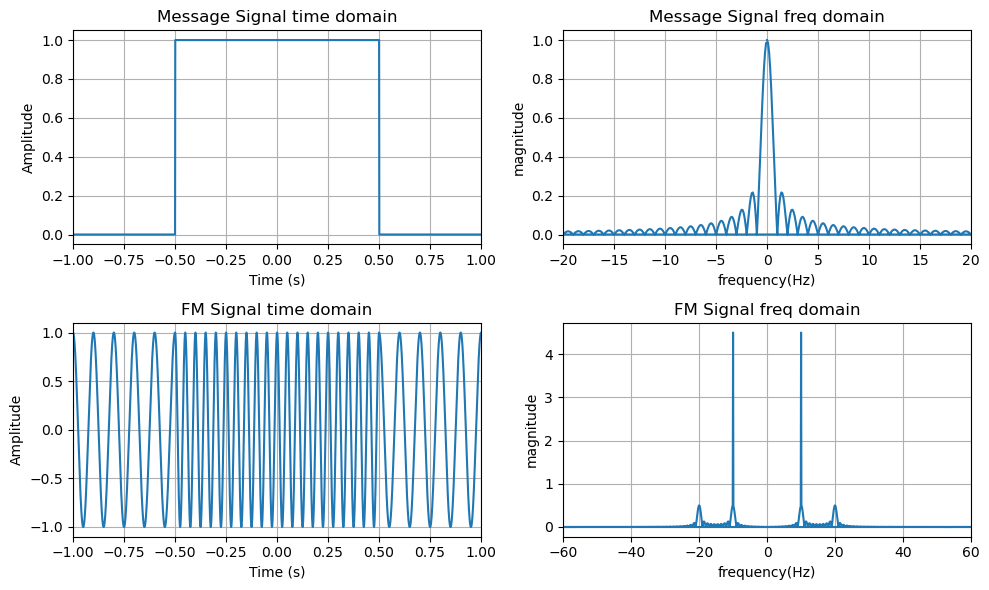

In [4]:
# Plot the message signal and FM signal
plt.figure(figsize=(10, 6))

# Message signal
plt.subplot(2, 2, 1)
plt.plot(t, m_t)
plt.title('Message Signal time domain')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.xlim(-1,1)

plt.subplot(2, 2, 2)
plt.plot(f1, abs(X1))
plt.title('Message Signal freq domain')
plt.xlabel('frequency(Hz)')
plt.ylabel('magnitude')
plt.grid()
plt.xlim(-20,20)  

# FM signal
plt.subplot(2, 2, 3)
plt.plot(t, fm_t)
plt.title('FM Signal time domain')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.xlim(-1,1) 

plt.subplot(2, 2, 4)
plt.plot(f2, abs(X2))
plt.title('FM Signal freq domain')
plt.xlabel('frequency(Hz)')
plt.ylabel('magnitude')
plt.grid()
plt.xlim(-60,60)  

plt.tight_layout()
plt.show()

# PJ6

In [5]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq, ifft

# Step 1: Obtain the FM modulated signal (fm_signal)
fm_signal = fm_t

# the freq domain
f2 = fftfreq(len(fm_t), d=1 / Fs)
X2 = fft(fm_t)/Fs

# Differentiation in the frequency domain
differentiated_spectrum = (2*np.pi*1j*f2) * X2

# Inverse Fourier Transform to obtain the differentiated signal
differentiated_signal = ifft(differentiated_spectrum).real*Fs

# Envelope detector
envelope = np.abs(signal.hilbert(differentiated_signal))

# envelop = 2*pi*Ac*(fc+kf*m(t))
demod_mt = (envelope/(2*np.pi*1)-Fc)/kf

#spectrum
demod_mt_spectrum = fft(demod_mt)/Fs


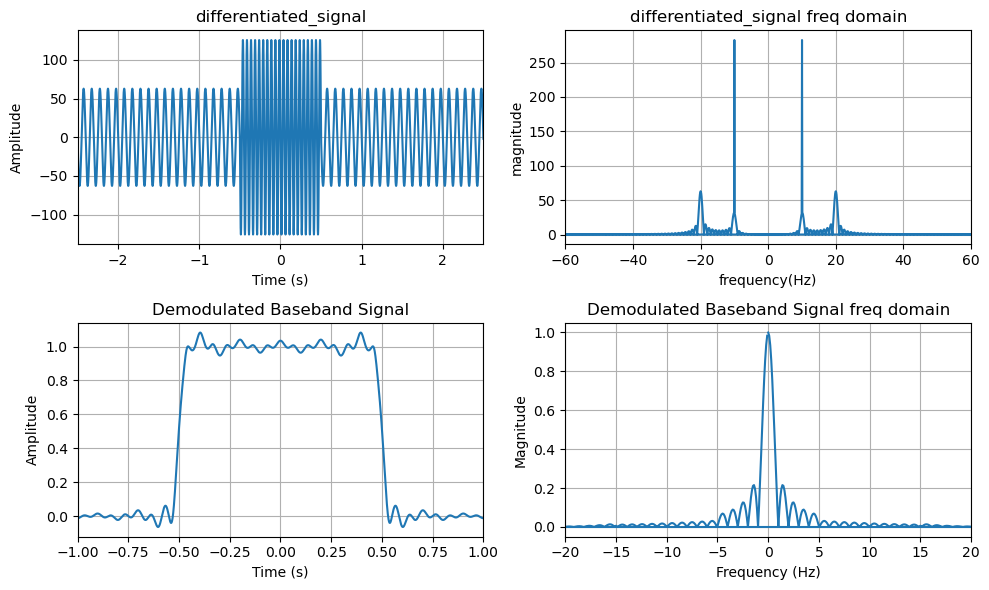

In [11]:
# Plotting the FM signal and the demodulated baseband signal
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(t, differentiated_signal)
plt.title('differentiated_signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.xlim(-2.5,2.5)  

plt.subplot(2, 2, 2)
plt.plot(f2, np.abs(differentiated_spectrum))
plt.title('differentiated_signal freq domain')
plt.xlabel('frequency(Hz)')
plt.ylabel('magnitude')
plt.grid()
plt.xlim(-60,60)  

plt.subplot(2, 2, 3)
plt.plot(t, demod_mt)
plt.title('Demodulated Baseband Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.xlim(-1,1)  

plt.subplot(2, 2, 4)
plt.plot(f2, np.abs(demod_mt_spectrum))
plt.title('Demodulated Baseband Signal freq domain')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid()
plt.xlim(-20,20)

plt.tight_layout()
plt.show()

# try to demodulation in pratice way

In [7]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq, ifft

# Step 1: Obtain the FM modulated signal (fm_signal)
fm_signal = fm_t

# the freq domain
f2 = fftfreq(len(fm_t), d=1 / Fs)
X2 = fft(fm_t)/Fs

# define transfer function H1(f) and H2(f)

def positive_slope(f,fc,BT):
    return np.where( (f >= fc-BT/2) & (f <= fc+BT/2), 1j*2*np.pi*(f-(fc-BT/2)), 0)

def negative_slope(f,fc,BT):
    return np.where( (f >= fc-BT/2) & (f <= fc+BT/2), 1j*2*np.pi*(-f+(fc+BT/2)), 0)

H1 = positive_slope(f2,Fc,30)
H2 = negative_slope(f2,Fc,30)

# Differentiation in the frequency domain
S1 = H1 * X2
S2 = H2 * X2

# Inverse Fourier Transform to obtain the differentiated signal
s1_t = ifft(S1).real*Fs
s2_t = ifft(S2).real*Fs

# Envelope detector
envelope1 = np.abs(signal.hilbert(s1_t))
envelope2 = np.abs(signal.hilbert(s2_t))

# envelop = 2*pi*Ac*kf*m(t)
demod_mt = (envelope1-envelope2)/(2*np.pi*1*kf)

#spectrum
demod_mt_spectrum = fft(demod_mt)/Fs

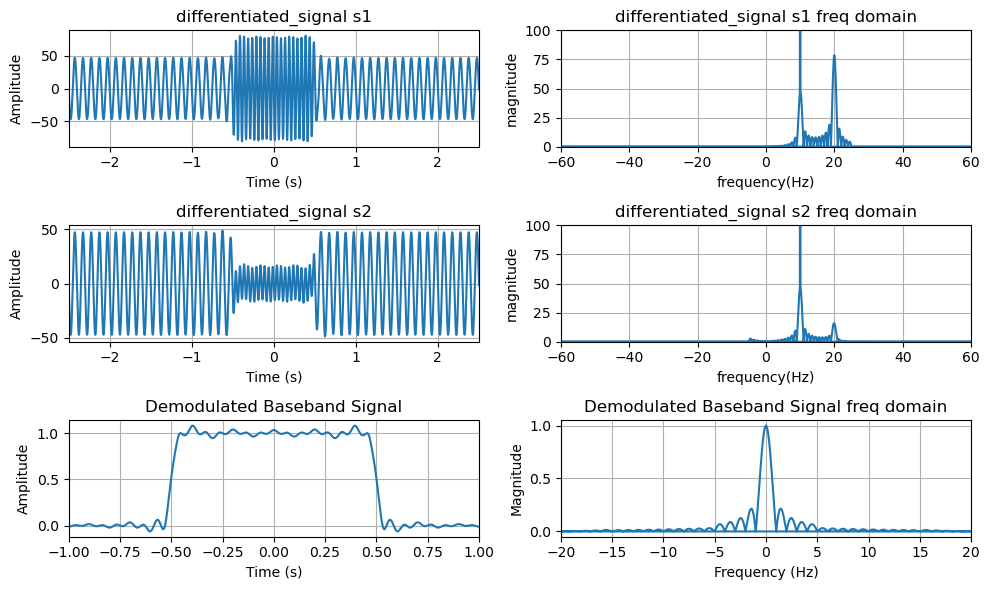

In [8]:
# Plotting the FM signal and the demodulated baseband signal
plt.figure(figsize=(10, 6))

plt.subplot(3, 2, 1)
plt.plot(t, s1_t)
plt.title('differentiated_signal s1')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.xlim(-2.5,2.5)  

plt.subplot(3, 2, 2)
plt.plot(f2, np.abs(S1))
plt.title('differentiated_signal s1 freq domain')
plt.xlabel('frequency(Hz)')
plt.ylabel('magnitude')
plt.grid()
plt.ylim(0,100) 
plt.xlim(-60,60)  

plt.subplot(3, 2, 3)
plt.plot(t, s2_t)
plt.title('differentiated_signal s2')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.xlim(-2.5,2.5)  

plt.subplot(3, 2, 4)
plt.plot(f2, np.abs(S2))
plt.title('differentiated_signal s2 freq domain')
plt.xlabel('frequency(Hz)')
plt.ylabel('magnitude')
plt.grid()
plt.ylim(0,100) 
plt.xlim(-60,60)  

plt.subplot(3, 2, 5)
plt.plot(t, demod_mt)
plt.title('Demodulated Baseband Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.xlim(-1,1)  

plt.subplot(3, 2, 6)
plt.plot(f2, np.abs(demod_mt_spectrum))
plt.title('Demodulated Baseband Signal freq domain')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid()
plt.xlim(-20,20)

plt.tight_layout()
plt.show()